# 1. Image Transforms

In [4]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# !git clone https://github.com/jaddoescad/ants_and_bees.git ../data

In [13]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0,shear=10, scale=(0.8,1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
training_dataset = datasets.ImageFolder(root="../data/ants_and_bees-master/train", transform=transform_train)
validation_dataset = datasets.ImageFolder(root="../data/ants_and_bees-master/val", transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=True)

In [14]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [18]:
class DeNormalize(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
    
def im_convert(tensor):
#     denorm = DeNormalize(mean=(0.5,), std=(0.5,))
    transform = transforms.Compose([DeNormalize((0.5,), (0.5,))])

    tensor = transform(tensor.clone().detach())
    tensor = tensor.permute(1,2,0)
    image = tensor.clip(0,1).cpu()
    return image

In [19]:
classes = ("ant", "bee")

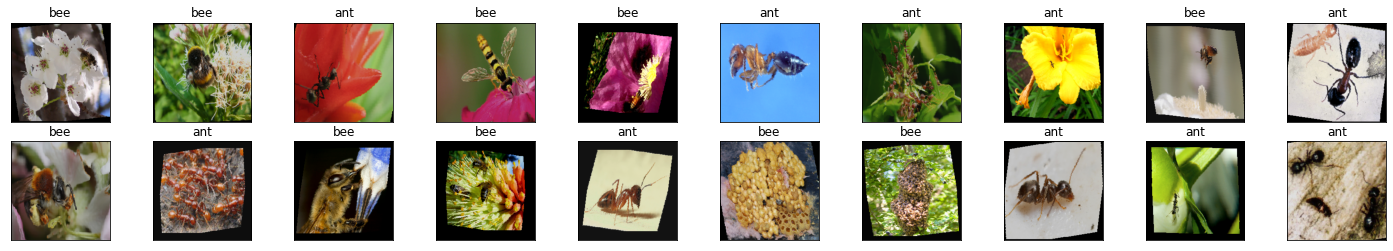

In [22]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

# 2. Neural Network Implementaion

## AlexNet

In [12]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [13]:
# model.reset_parameters()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        # images shape: 1, 28, 28
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                # images shape: 1, 28, 28
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                                     
        epoch_loss = running_loss/len(training_loader.dataset)
        epoch_acc = running_corrects.float()/len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print(f"epoch: {e+1}")
        print(f"training loss: {epoch_loss:.4f} acc: {epoch_acc.item():.4f} ")
        print(f"validation loss: {val_epoch_loss:.4f} validation acc: {val_epoch_acc.item():.4f} ")

epoch: 1
training loss: 0.5901 acc: 83.9550 
validation loss: 0.1847 validation acc: 94.7800 
epoch: 2
training loss: 0.1509 acc: 95.4800 
validation loss: 0.1058 validation acc: 96.8600 
epoch: 3
training loss: 0.0972 acc: 97.1083 
validation loss: 0.0781 validation acc: 97.6400 
epoch: 4
training loss: 0.0750 acc: 97.7567 
validation loss: 0.0578 validation acc: 98.2600 
epoch: 5
training loss: 0.0614 acc: 98.1117 
validation loss: 0.0519 validation acc: 98.3200 
epoch: 6
training loss: 0.0542 acc: 98.3417 
validation loss: 0.0464 validation acc: 98.5800 
epoch: 7
training loss: 0.0477 acc: 98.5017 
validation loss: 0.0416 validation acc: 98.6600 


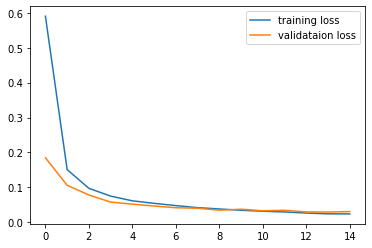

In [17]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validataion loss")
plt.legend()

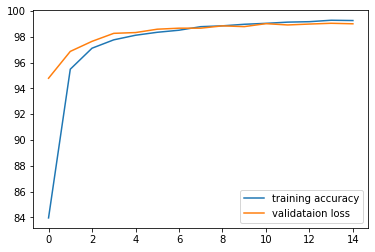

In [18]:
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validataion loss")
plt.legend()

# 3. Test Model

### Preprocess Image

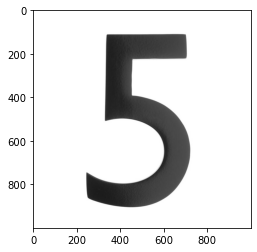

In [36]:
import requests
from PIL import Image, ImageOps
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

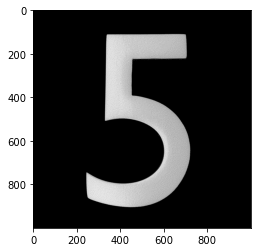

In [37]:
img = ImageOps.invert(img)
img = img.convert("1")
plt.imshow(img)

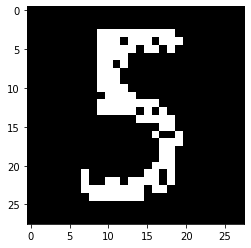

In [38]:
img = transform(img)
plt.imshow(im_convert(img))

### Predict

In [62]:
images = img.to(device)
# image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


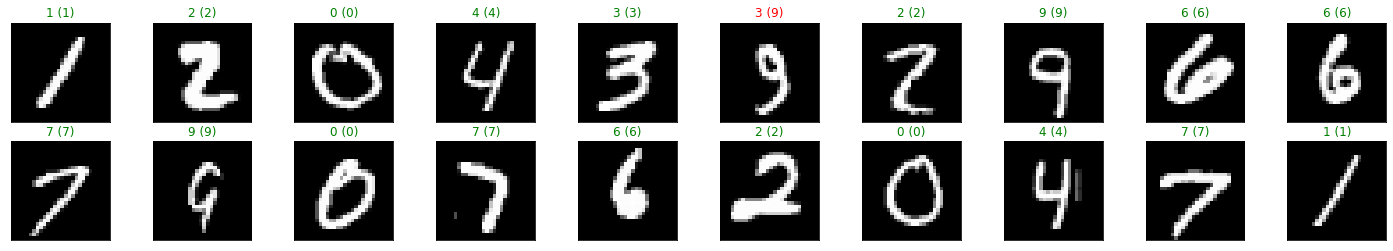

In [71]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(f"{preds[idx].item()} ({classes[labels[idx].item()]})", color=("green" if preds[idx]==labels[idx] else "red"))

# Appendix

## Tunning Process

#### Tuning 전: 63.04 val acc

In [ ]:
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(5*5*50, 500) # 4*4 = the size of feture map, 50= the number of feature maps
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*50) # flatten()
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
    
# model.reset_parameters()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#### Tuning 1: 69.12 val acc